In [1]:
import numpy as np
import pandas as pd

In [2]:
import nltk
from nltk.corpus import twitter_samples

nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


True

In [3]:
##  seperating positive and negative tweets
positiveTweets = twitter_samples.strings('positive_tweets.json')
negativeTweets = twitter_samples.strings('negative_tweets.json')
all_tweets = positiveTweets + negativeTweets

In [4]:
## text cleaning
import re

def clean_text(tweet):
    tweet = re.sub(r'@[A-Za-z0-9_]+', '',  tweet)  ### removing mentions in the tweet
    tweet = re.sub(r'#', '',  tweet)  ## removing hashtags
    tweet = re.sub(r'http\S+', '', tweet)  #  removing URLs starting with "http
    tweet = re.sub(r'[^A-Za-z ]+', '', tweet)  # removing  non-alphabetic characters except space
    tweet=  tweet.lower()   ### converting the entire tweet to lowercase

    return  tweet

    cleaned_tweets = [clean_text(tweet) for tweet in all_tweets]



In [5]:
                                  # ********* tokenization(to break text into indivisual units called tokens) **********
from nltk.corpus import twitter_samples
from nltk.tokenize import TweetTokenizer
# The just below code is setting all words to lower case , removing twitter handles and  reducing the length of repeated characters
tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

pos_tokens = [tweet_tokenizer.tokenize(tweet) for tweet in positiveTweets]
neg_tokens = [tweet_tokenizer.tokenize(tweet) for tweet in negativeTweets]
cleaned_tokenized_tweets = [tweet_tokenizer.tokenize(clean_text(tweet)) for tweet in all_tweets]

# print(cleaned_tokenized_tweets)


In [6]:
all_tokens =  cleaned_tokenized_tweets
labels = [1] * len(positiveTweets) + [0] * len(negativeTweets)    ## --> 1 mean pos tweets and 0 means neg ones

In [7]:
print(len(all_tokens))
print(len(labels))  # both the length must be equal for further processes that's why checking if it is going well

10000
10000


In [8]:
from sklearn.model_selection import train_test_split

train_tokens, test_tokens, train_labels, test_labels = train_test_split(all_tokens, labels, test_size=0.2, random_state=42)


In [9]:
from nltk.stem import PorterStemmer   # stemming is a text normalization technique . Its main purpose o is to simplify words by removing suffixes or prefixes
porter_stemmer = PorterStemmer()

In [10]:
train_stemmed_tokens = [[porter_stemmer.stem(word) for word in tokens] for tokens in train_tokens]

test_stemmed_tokens = [[porter_stemmer.stem(word) for word in tokens] for tokens in test_tokens]

# print(test_stemmed_tokens)


In [11]:
def handle_negation(tokens):  ##  important, so that 'good' and 'not good' are not interpreted as same review
    negation_words = ['not', 'no', 'isn\'t', 'don\'t', 'doesn\'t', 'cannot', 'can\'t']

    negation_pattern = re.compile(r'\b(?:' + '|'.join(negation_words) + r')\b(\w+)')

    def add_not_prefix(match):
        return 'not_' + match.group(1)

    tokens_with_negation = [negation_pattern.sub(add_not_prefix, token) for token in tokens]

    return tokens_with_negation

train_with_negation = [handle_negation(tokens) for tokens in train_stemmed_tokens]
test_with_negation = [handle_negation(tokens) for tokens in test_stemmed_tokens]

# print(test_with_negation)




In [12]:
def expand_contractions(tokens):
    contraction_mapping = { "cant": "cannot", "wont": "will not", "'m": " am", "'ll": " will","'s":" is","'re": " are", "'d": " would", "nt": " not", "'ve": " have","'cause": "because",
    "couldve": "could have",
    "couldnt": "could not","cant":"cannot","dont":"do not",
    "didnt": "did not",
    "doesnt": "does not","lets": "let us","mustnt": "must not",
    "neednt": "need not","wasnt": "was not","oughtn't": "ought not",
    "shallnt": "shall not",
    "shed": "she would","maam": "madam","yall": "you all"}

    text = ' '.join(tokens)

    contraction_pattern = re.compile(r'\b(?:%s)\b' % '|'.join(contraction_mapping.keys()))
    expanded_text = contraction_pattern.sub(lambda match: contraction_mapping[match.group(0)], tokens)

    expanded_tokens = expanded_text.split()

    return expanded_tokens

expanded_train_tokens = [[expand_contractions(token) for token in tokens] for tokens in train_with_negation]
expanded_test_tokens = [[expand_contractions(token) for token in tokens] for tokens in test_with_negation]

# print(expanded_test_tokens)

In [13]:
def handle_emoticons_abbreviations(tokens):
    emoticon_mapping = {
        "lol": "laugh out loud",
        "brb": "be right back",
        "btw": "by the way",
        "omg": "oh my god",
        "ASAP": "As soon as possible",
         "pls": "please","bday":"birthday",
    "thx": "thanks","im":"i am",
    "afaik": "as far as i know","havent":"have not",
    "imo": "in my opinion","didnt":"did not",
    "ngl":"not going to lie", "rt":"retweet","bae":"before anyone else",
    "ngl":"not going to lie", "rt":"retweet",
        "wanna":"want to","gonna":"going to",
        "lmao":"laughing my ass off", "lmfao":"laughing my freaking ass off", "TBH": "To be honest","bts": "Behind the scenes","IDK": "I do not know","HBD": "Happy birthday",
    "emm":"email me","gratz": "congratulations","pov":"Point of view","wasnt":"was not","tmrw":"tomorrow","dm":"direct message","gal":"girl","boi":"boy"
    }

    text = ' '.join(tokens)

    for emoticon, meaning in emoticon_mapping.items():
        text = text.replace(emoticon, meaning)

    abbreviation_mapping = {
        "u": "you",
        "r": "are",
        "2": "to",
        "4": "for",
        "gr8": "great",
    "xd":"Laugh Out Loud",
    "P": "tongue out",
    "b4": "before","fam": "family"


    }

    for abbreviation, expansion in abbreviation_mapping.items():
        text = re.sub(r'\b%s\b' % re.escape(abbreviation), expansion, text)

    expanded_tokens = text.split()

    return expanded_tokens

cleaned_train_tokens = [[handle_emoticons_abbreviations(token) for token in tokens] for tokens in expanded_train_tokens]
cleaned_test_tokens = [[handle_emoticons_abbreviations(token) for token in tokens] for tokens in expanded_test_tokens]

# print(cleaned_test_tokens)


In [14]:
# removing stopwords
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def removing_stopwords(tokens_list):
    stop_words = set(stopwords.words('english'))
    flattened_tokens = [token for tokens in tokens_list for token in tokens]
    filtered_tokens = [token for token in flattened_tokens if token not in stop_words]
    return filtered_tokens

stopwords_free_train_tokens = [removing_stopwords(tokens) for tokens in cleaned_train_tokens]
stopwords_free_test_tokens = [removing_stopwords(tokens) for tokens in cleaned_test_tokens]

# print(stopwords_free_test_tokens)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
# Vectorization is the process of converting non-numeric data (such as text, images, or categorical features) into a numerical format.
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
text_train = [' '.join(tokens) for tokens in stopwords_free_train_tokens]  ### concatenate the tokens of each tweet into a single string separated by spaces
text_test = [' '.join(tokens) for tokens in stopwords_free_test_tokens]
tfidf_vectorizer = TfidfVectorizer()   #implementation of the TF-IDF vectorization
X_train_tfidf = tfidf_vectorizer.fit_transform(text_train)
X_test_tfidf = tfidf_vectorizer.transform(text_test)  # transforming the respective data set into TF-IDF representations.
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)

Shape of X_train_tfidf: (8000, 8586)
Shape of X_test_tfidf: (2000, 8586)


In [16]:
                                            # ******* LOGISTIC REGERSSION*******

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,recall_score,roc_auc_score,precision_score,roc_curve

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf, train_labels, test_size=0.2, random_state=50) # 80% data--> training ,rest for testing
# in above , 'random_seed' helps to fix the data splitted for specific set
logreg_model = LogisticRegression(random_state=50)

logreg_model.fit(X_train, y_train)  # training the model on the training data

predictions = logreg_model.predict(X_val)  # here X_val is the input for predicting corresponding class labels

accuracy = accuracy_score(y_val, predictions)
print(f'Accuracy: {accuracy:.4f}')

print('\nClassification Report:')
print(classification_report(y_val, predictions))


Accuracy: 0.7525

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.76       793
           1       0.77      0.73      0.75       807

    accuracy                           0.75      1600
   macro avg       0.75      0.75      0.75      1600
weighted avg       0.75      0.75      0.75      1600



In [17]:
test_predictions = logreg_model.predict(X_test_tfidf)   # prediction on test set

test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.7405


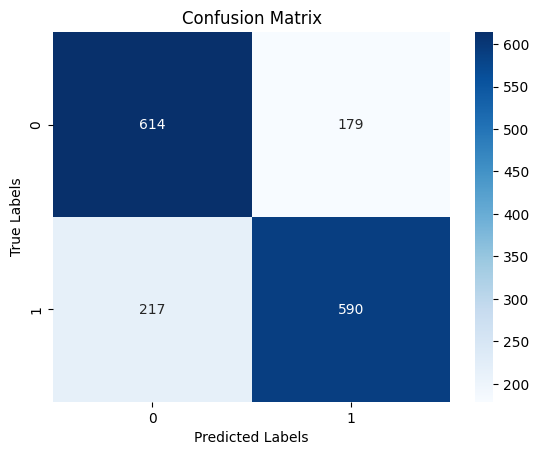

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


conf_matrix = confusion_matrix(y_val, predictions)
labels = np.unique(y_val)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()